In [100]:
# Import required libraries
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np


In [84]:
# Load the dataset
data = pd.read_csv('airflow_cleaned_data_unscaled.csv')

# Define features and sensitive attributes
X = data.drop(columns=["COHORT", "ENROLL_AGE", "SEX"])  # Drop target and sensitive features
y = data["COHORT"]
sensitive_features = data[["ENROLL_AGE", "SEX"]]  # Sensitive features for fairness evaluation

# # Label encode the target variable
y = LabelEncoder().fit_transform(y)

# Bin the 'ENROLL_AGE' feature into ranges
sensitive_features["ENROLL_AGE_GROUPS"] = pd.cut(
    sensitive_features["ENROLL_AGE"],
    bins=[0, 20, 40, 60, 80, 100],  # Define bins (adjust as needed)
    labels=["0-20", "21-40", "41-60", "61-80", "81+"],
    right=False
)

C:\Users\yutik\AppData\Local\Temp\ipykernel_1816\3857330621.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensitive_features["ENROLL_AGE_GROUPS"] = pd.cut(


In [85]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test, sensitive_features_train, sensitive_features_test = train_test_split(
    X, y, sensitive_features, test_size=0.2, random_state=42
)


In [86]:
# Define the models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "XGBoost": XGBClassifier( eval_metric='mlogloss', random_state=42)
}

# Initialize results dictionary
results = {}



Training and evaluating Random Forest...
Accuracy for Random Forest: 0.9010695187165776

Training and evaluating SVM...
Accuracy for SVM: 0.8676470588235294

Training and evaluating Logistic Regression...
Accuracy for Logistic Regression: 0.9090909090909091

Training and evaluating XGBoost...
Accuracy for XGBoost: 0.9157754010695187


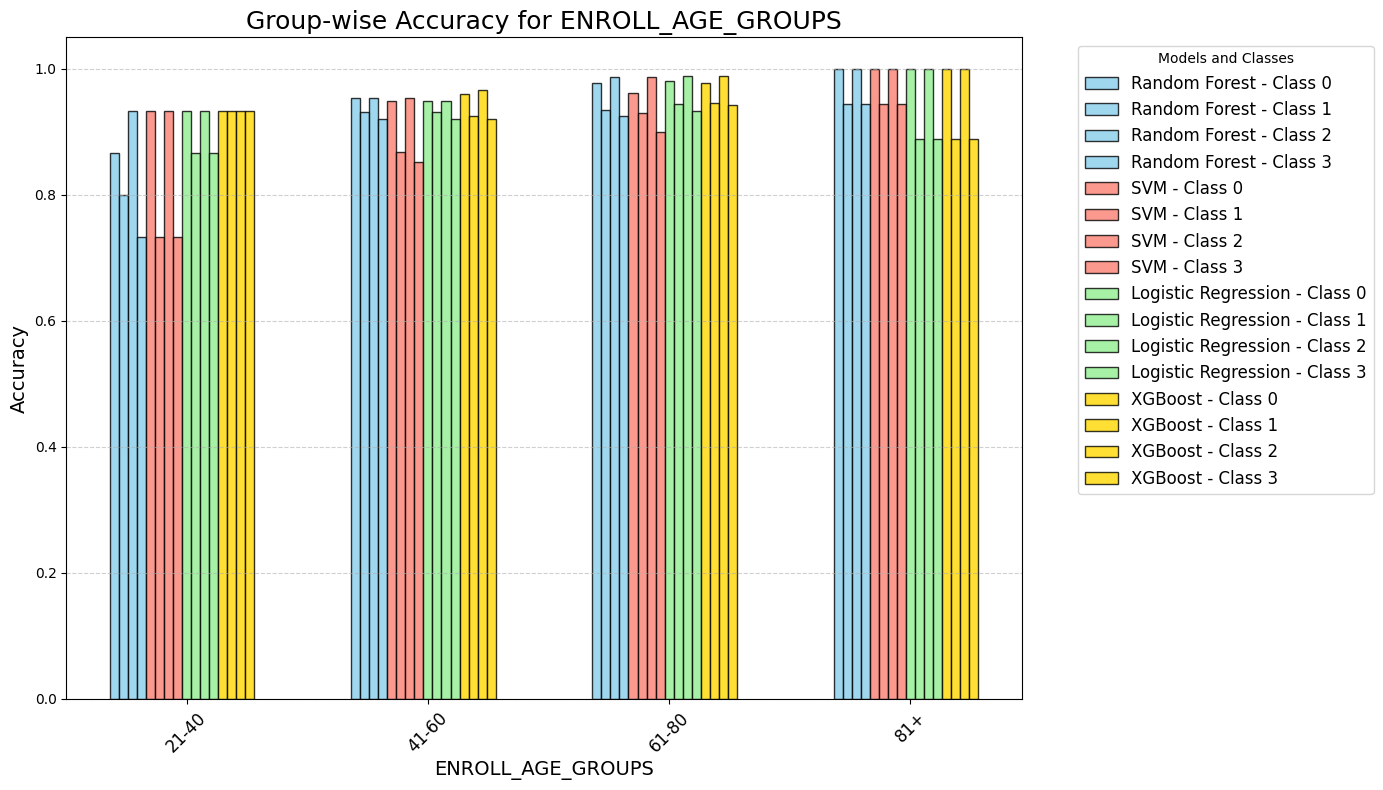

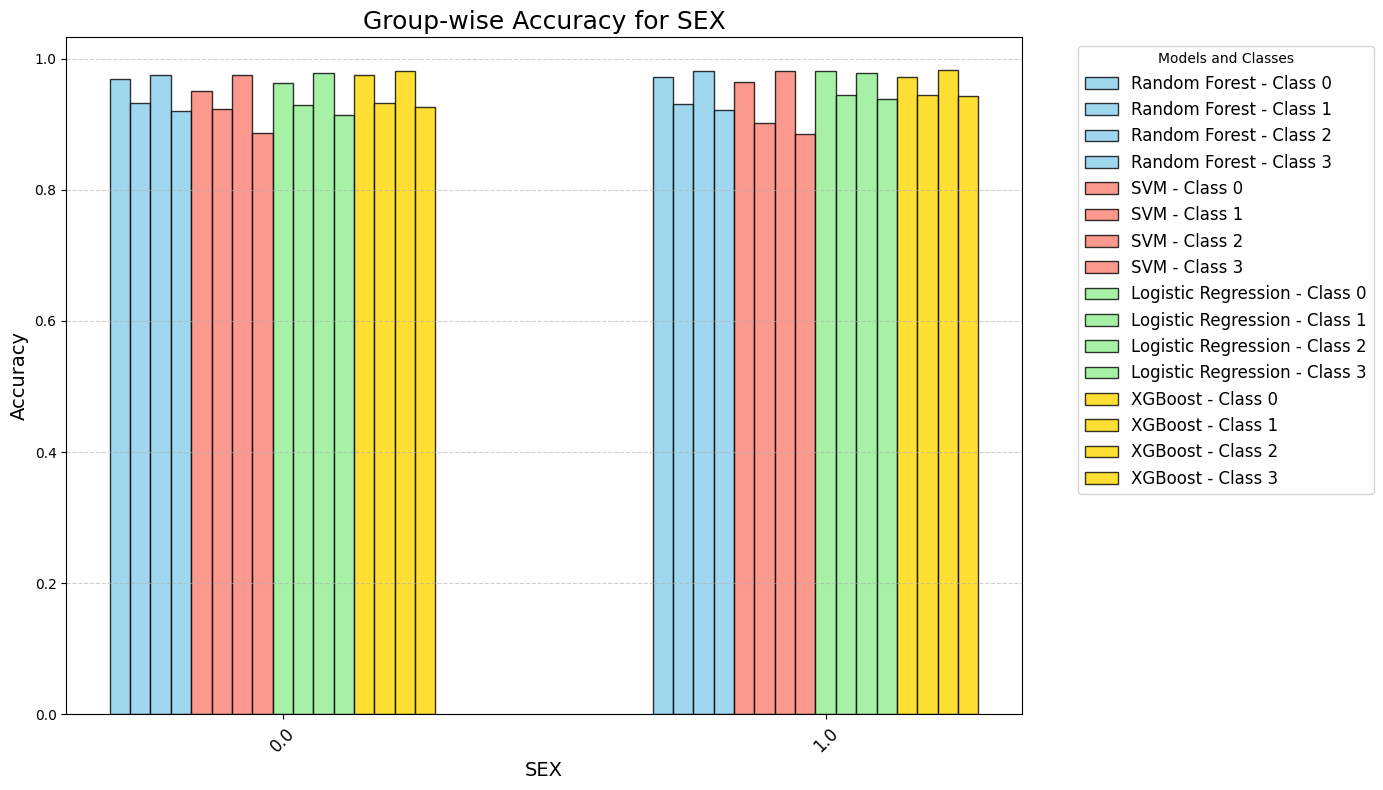

In [101]:
# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining and evaluating {model_name}...")
    
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Store overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {accuracy}")
    
    # Fairness Evaluation using One-vs-Rest
    fairness_report = {}
    for class_label in np.unique(y_test):
        y_test_binary = (y_test == class_label).astype(int)
        y_pred_binary = (y_pred == class_label).astype(int)
        
        for feature in ["ENROLL_AGE_GROUPS", "SEX"]:
            dp_diff = demographic_parity_difference(y_test_binary, y_pred_binary, sensitive_features=sensitive_features_test[feature])
            eo_diff = equalized_odds_difference(y_test_binary, y_pred_binary, sensitive_features=sensitive_features_test[feature])

      
            
            # Group-wise accuracy
            metric_frame = MetricFrame(metrics=accuracy_score,
                                       y_true=y_test_binary,
                                       y_pred=y_pred_binary,
                                       sensitive_features=sensitive_features_test[feature])
            
            # Save fairness metrics
            fairness_report[(class_label, feature)] = {
                "Demographic Parity Difference": dp_diff,
                "Equalized Odds Difference": eo_diff,
                "Accuracy by Group": metric_frame.by_group.to_dict()
            }

    
    # Store results for the model
    results[model_name] = {
        "accuracy": accuracy,
        "fairness_report": fairness_report
    }




    # Step 2: Add the Visualization Function
def visualize_accuracy_for_models(results, sensitive_features, classes):
    """
    Creates overlapping bar charts for accuracy across all models for each sensitive feature.

    Args:
        results (dict): Dictionary containing accuracy and fairness metrics for each model.
        sensitive_features (list): List of sensitive features to evaluate (e.g., ["ENROLL_AGE_GROUPS", "SEX"]).
        classes (list): List of class labels from COHORT.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from itertools import cycle
    
    # Define an expanded color palette
    model_colors = cycle([
        "skyblue", "salmon", "lightgreen", "gold"
    ])

    for feature in sensitive_features:
        plt.figure(figsize=(14, 8))
        groups = None

        # Extract groups for the sensitive feature
        for model_name, result in results.items():
            sample_fairness_report = result["fairness_report"]
            for (class_label, feat), metrics in sample_fairness_report.items():
                if feat == feature:
                    groups = list(metrics["Accuracy by Group"].keys())
                    break
            if groups:
                break

        if not groups:
            print(f"No data found for feature: {feature}")
            continue

        # Define positions for groups and bar width
        group_positions = np.arange(len(groups))
        bar_width = 0.15  # Reduced width for more models and classes

        # Initialize color iterator
        current_colors = [next(model_colors) for _ in results.keys()]

        # Plot accuracies for each model
        for model_idx, model_name in enumerate(results.keys()):
            for class_idx, class_label in enumerate(classes):
                if (class_label, feature) in results[model_name]["fairness_report"]:
                    accuracy_by_group = results[model_name]["fairness_report"][(class_label, feature)]["Accuracy by Group"]
                    accuracies = [accuracy_by_group[group] for group in groups]

                    # Offset each bar for overlap
                    bar_positions = [
                        p + (model_idx * bar_width) - (bar_width * len(results) / 2) + (class_idx * (bar_width / len(classes)))
                        for p in group_positions
                    ]

                    plt.bar(bar_positions, accuracies, 
                            bar_width / len(classes),
                            label=f"{model_name} - Class {class_label}",
                            color=current_colors[model_idx % len(current_colors)],
                            alpha=0.8,
                            edgecolor='black')  # Add border to each bar

        # Add titles, labels, and legend
        plt.title(f"Group-wise Accuracy for {feature}", fontsize=18)
        plt.xlabel(f"{feature}", fontsize=14)
        plt.ylabel("Accuracy", fontsize=14)
        plt.xticks(group_positions, groups, rotation=45, fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12, title="Models and Classes")
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

# Step 3: Visualize Accuracy
sensitive_features = ["ENROLL_AGE_GROUPS", "SEX"]
classes = np.unique(y_test)  # Assuming y_test contains the class labels

visualize_accuracy_for_models(results, sensitive_features, classes)

